### Import Libraries

In [1]:
import pandas_datareader as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.utils import plot_model
import warnings
warnings.filterwarnings("ignore")

### Get Data

In [2]:
api_key = '78f064b56cef41ed48ee76b18d2d456a6ea286bb'
df_twitter = pdr.tiingo.TiingoDailyReader('TWTR', api_key = api_key).read()

In [3]:
dataframes = [df_twitter]
column_names = ['date', 'open']
df_twitter.shape, df_twitter.head(), df_twitter.tail()

((1241, 12),
                                   close   high    low   open    volume  \
 symbol date                                                              
 TWTR   2017-11-24 00:00:00+00:00  22.42  22.48  22.17  22.40   7584013   
        2017-11-27 00:00:00+00:00  21.82  22.40  21.70  22.36  19655728   
        2017-11-28 00:00:00+00:00  21.83  22.15  21.56  21.85  13813538   
        2017-11-29 00:00:00+00:00  20.79  22.11  20.52  21.82  23684010   
        2017-11-30 00:00:00+00:00  20.58  21.12  20.51  21.01  15823241   
 
                                   adjClose  adjHigh  adjLow  adjOpen  \
 symbol date                                                            
 TWTR   2017-11-24 00:00:00+00:00     22.42    22.48   22.17    22.40   
        2017-11-27 00:00:00+00:00     21.82    22.40   21.70    22.36   
        2017-11-28 00:00:00+00:00     21.83    22.15   21.56    21.85   
        2017-11-29 00:00:00+00:00     20.79    22.11   20.52    21.82   
        2017-11-30 00:

In [4]:
for count, df in enumerate(dataframes):
    df.reset_index(inplace=True)
    df = df[column_names]
    df.to_csv('data' + str(count) + '.csv')

In [5]:
def train_test_split(df, split):
    length = len(df)
    train = round(length * split)
    valid = round(length - train)
    print("Original length: ", length)
    print("Train length: ", train)
    print("Valid length: ", valid)
    train_data = df[:train]
    validation_data = df[train:]
    return train_data, validation_data

In [6]:
def prepare_data(data, time_step):
    X, y = [], []
    length = len(data)
    # Sliding window
    for i in range(time_step, length):
        X.append(data[i-time_step:i,0])
        y.append(data[i,0])
        
    # Convert to arrays:
    X, y = np.array(X), np.array(y)
    
    # Reshaping
    X = np.reshape(X, (X.shape[0], X.shape[1],1))
    y = np.reshape(y, (y.shape[0],1))
    
    return X, y

### Training

In [7]:
def train(stock_name, stock_data, split, time_step = 50):
    print(f"Training on {stock_name} stock data")
    # Train-Test Split
    train_data, valid_data = train_test_split(stock_data, split)
    
    # Train data and reshape
    X_train = train_data.open.values
    X_train = X_train.reshape(-1, 1) #column vector made
    
    # Scaler
    scaler = MinMaxScaler(feature_range = (0,1)) #defining scaler
    
    # Re-scale
    X_train = scaler.fit_transform(X_train) #scaling
    
    # Plot Stock Data - Training
    plt.subplots(figsize = (15,6))
    plt.plot(scaler.inverse_transform(X_train))
    plt.xlabel("Days")
    plt.ylabel("Open Price")
    plt.title(f'{stock_name} Stock Data (Train)')
    plt.savefig(f'data-{stock_name}.png')
    plt.show()
    
    X_train, y_train = prepare_data(X_train, time_step)
    print("Shape of X_train: ", X_train.shape)
    print("Shape of y_train: ", y_train.shape)
    
    # Simple RNN
    simplernn = Sequential(name = f'SimpleRNN-{stock_name}')
    simplernn.add(SimpleRNN(50, activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
    simplernn.add(Dropout(0.2))
    simplernn.add(SimpleRNN(50, activation='tanh', return_sequences = True))
    simplernn.add(Dropout(0.2))
    simplernn.add(SimpleRNN(50, activation='tanh', return_sequences = True))
    simplernn.add(Dropout(0.2))
    simplernn.add(SimpleRNN(50, activation='tanh'))
    simplernn.add(Dropout(0.2))
    simplernn.add(Dense(1))
    plot_model(simplernn, to_file='rnn.png', show_shapes=True)

    # Compiling the model
    simplernn.compile(optimizer = "adam", loss = "mean_squared_error")
    print(simplernn.summary())
    
    # Run the model
    print(f"\nTraining SimpleRNN model on {stock_name} data")
    historysimplernn = simplernn.fit(X_train, y_train, epochs = 50, batch_size = 32, verbose = 1)
    
    # Loss vs Epoch
    plt.figure(figsize =(10,7))
    plt.plot(historysimplernn.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(f"Loss vs Epoch (SimpleRNN {stock_name})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Training Data Prediction & Plot
    y_pred = simplernn.predict(X_train)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_train), color = "b", label = "y_train")
    plt.plot(scaler.inverse_transform(y_pred), color = "orange", label = "y_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"Simple RNN model - {stock_name}, Training Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-training-{time_step}-rnn.png')
    plt.show()
    
    
    # Validation
    X_test = valid_data.open.values
    X_test = X_test.reshape(-1, 1)
    X_test = scaler.fit_transform(X_test)
    X_test, y_test = prepare_data(X_test, 50)
    print("Shape of X_test: ", X_test.shape)
    print("Shape of y_test: ", y_test.shape)
    
    # Test Data Predictions & Plot
    y_test_pred = simplernn.predict(X_test)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_test), color = "b", label = "y_test")
    plt.plot(scaler.inverse_transform(y_test_pred), color = "orange", label = "y_test_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"Simple RNN model - {stock_name}, Test Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-validation-{time_step}-rnn.png')
    plt.show()
    
    
    # RMSE Error
    rnn_rmse_train = mean_squared_error(scaler.inverse_transform(y_train), scaler.inverse_transform(y_pred))
    rnn_rmse_test = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_pred))
    
    # LSTM Define & Train
    lstm = Sequential(name = f'LSTM-{stock_name}')
    lstm.add(LSTM(64,return_sequences=True,input_shape = (X_train.shape[1],1)))
    lstm.add(LSTM(64, return_sequences= False))
    lstm.add(Dense(32))
    lstm.add(Dense(1))
    lstm.compile(loss = "mean_squared_error", optimizer = "adam")
    print(f"\nTraining LSTM model on {stock_name} data")
    historylstm = lstm.fit(X_train, y_train, epochs=50, batch_size = 32, verbose = 1)
    plot_model(lstm, to_file='model_lstm.png')
    print(lstm.summary())

    
    # Loss vs Epoch
    plt.figure(figsize =(10,7))
    plt.plot(historylstm.history["loss"])
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.title(f"Loss vs Epoch (LSTM {stock_name})")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # Training Data Prediction & Plot
    y_pred = lstm.predict(X_train)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_train), color = "b", label = "y_train")
    plt.plot(scaler.inverse_transform(y_pred), color = "orange", label = "y_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"LSTM model - {stock_name}, Training Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-training-{time_step}-lstm.png')
    plt.show()
    
    # Test Data Predictions & Plot
    y_test_pred = lstm.predict(X_test)
    plt.figure(figsize = (30,10))
    plt.plot(scaler.inverse_transform(y_test), color = "b", label = "y_train")
    plt.plot(scaler.inverse_transform(y_test_pred), color = "orange", label = "y_pred" )
    plt.xlabel("Days")
    plt.ylabel("Open price")
    plt.title(f"LSTM model - {stock_name}, Test Data Prediction")
    plt.legend()
    plt.savefig(f'{stock_name}-training-{time_step}-lstm.png')
    plt.show()
    
    
    # RMSE Error
    lstm_rmse_train = mean_squared_error(scaler.inverse_transform(y_train), scaler.inverse_transform(y_pred))
    lstm_rmse_test = mean_squared_error(scaler.inverse_transform(y_test), scaler.inverse_transform(y_test_pred))
    
    
    # Saving
    simplernn.save(f'simplernn-{stock_name}-{str(time_step)}.h5')
    lstm.save(f'lstm-{stock_name}-{str(time_step)}.h5')
    return (time_step, rnn_rmse_train, rnn_rmse_test, lstm_rmse_train, lstm_rmse_test)
    

Training on Twitter stock data
Original length:  1241
Train length:  869
Valid length:  372


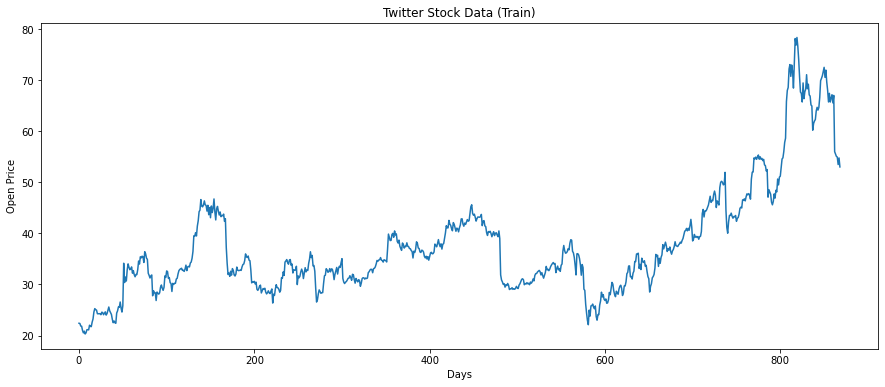

Shape of X_train:  (829, 40, 1)
Shape of y_train:  (829, 1)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "SimpleRNN-Twitter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 40, 50)            2600      
                                                                 
 dropout (Dropout)           (None, 40, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 40, 50)            5050      
                                                                 
 dropout_1 (Dropout)         (None, 40, 50)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40, 50)            5050      
                                      

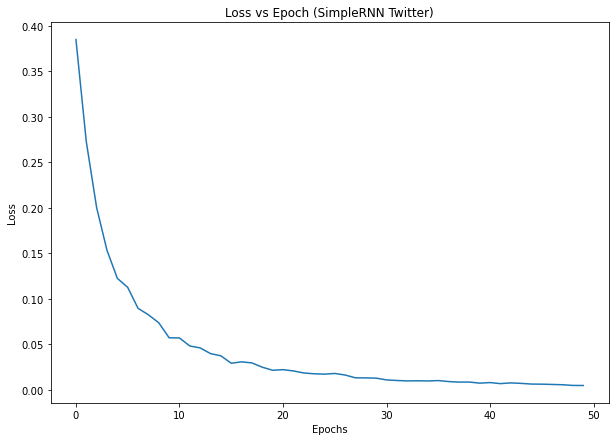

26/26 [==============================] - 1s 5ms/step


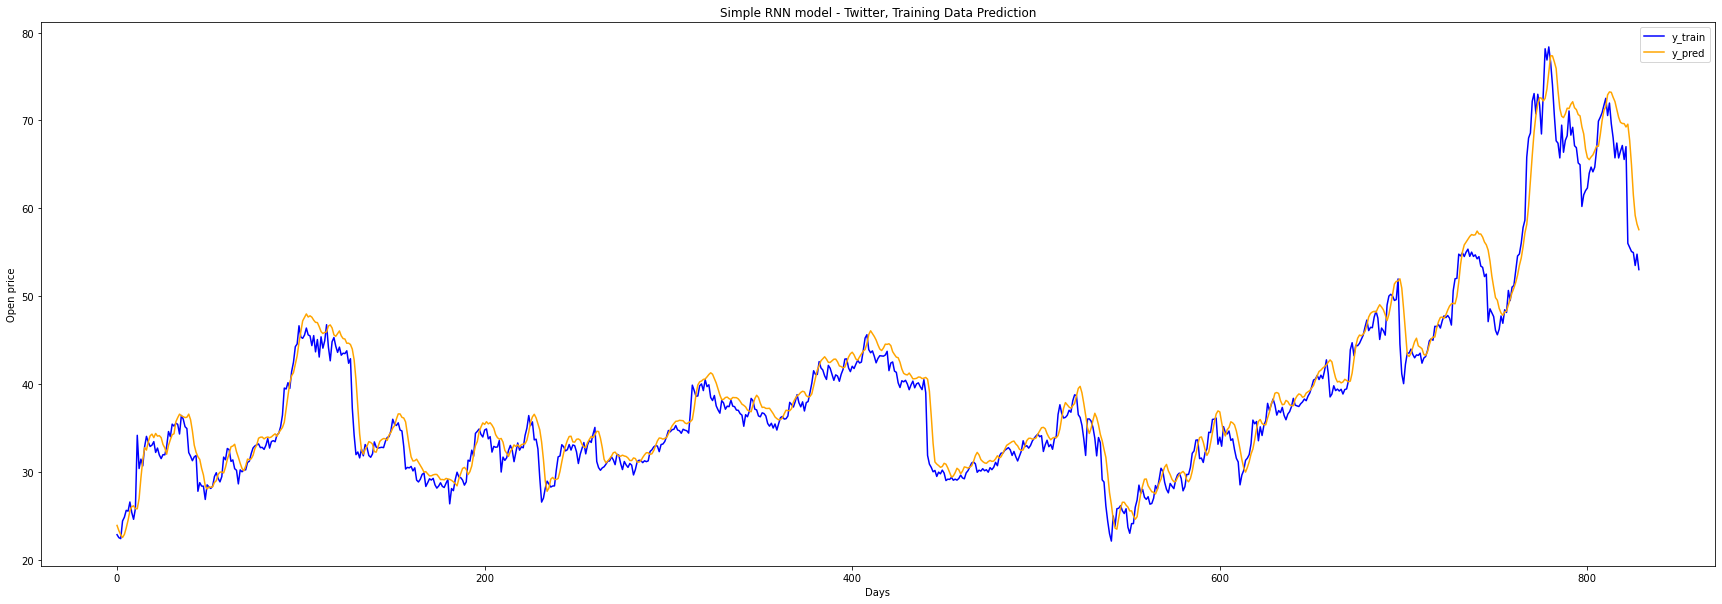

Shape of X_test:  (322, 50, 1)
Shape of y_test:  (322, 1)
11/11 [==============================] - 1s 6ms/step


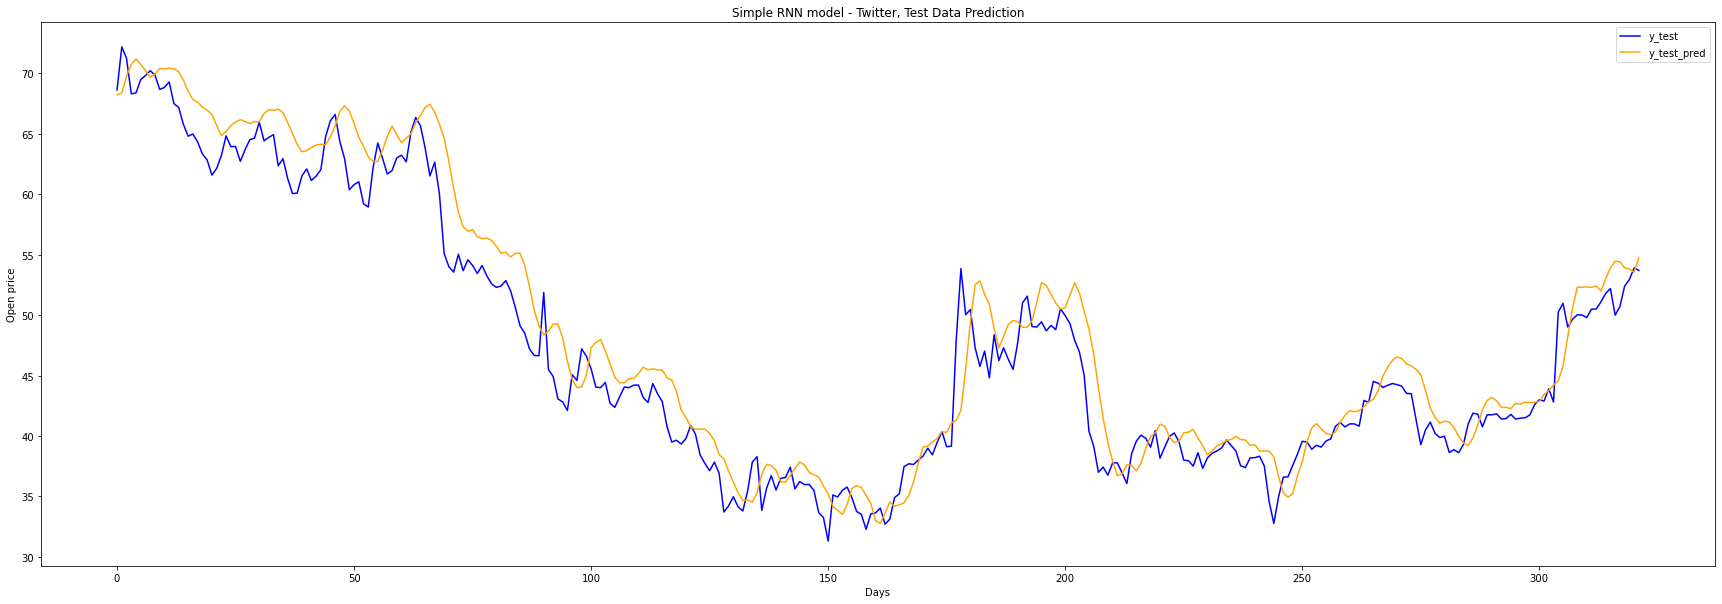


Training LSTM model on Twitter data
Epoch 1/50
83/83 [==============================] - 8s 25ms/step - loss: 0.0059
Epoch 2/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0026
Epoch 3/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0018
Epoch 4/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0015
Epoch 5/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0016
Epoch 6/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0014
Epoch 7/50
83/83 [==============================] - 2s 25ms/step - loss: 0.0016
Epoch 8/50
83/83 [==============================] - 2s 25ms/step - loss: 0.0013
Epoch 9/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0011
Epoch 10/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0010
Epoch 11/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0010
Epoch 12/50
83/83 [==============================] - 2s 24ms/step - loss: 0.0011


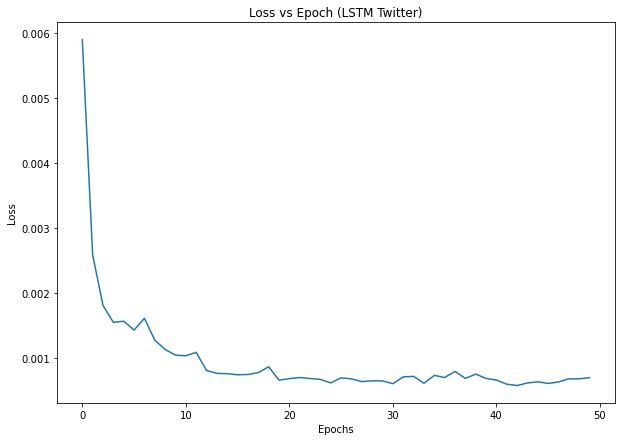

26/26 [==============================] - 2s 9ms/step


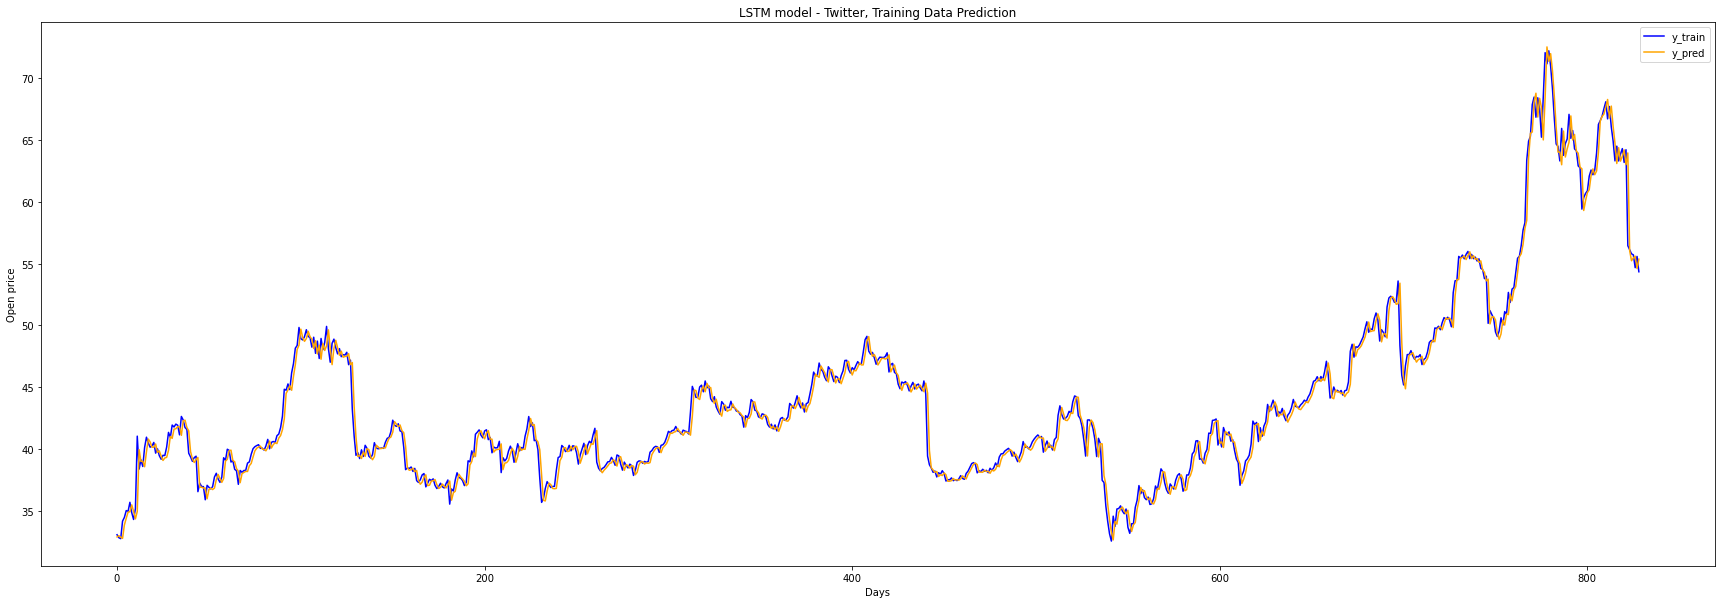

11/11 [==============================] - 1s 10ms/step


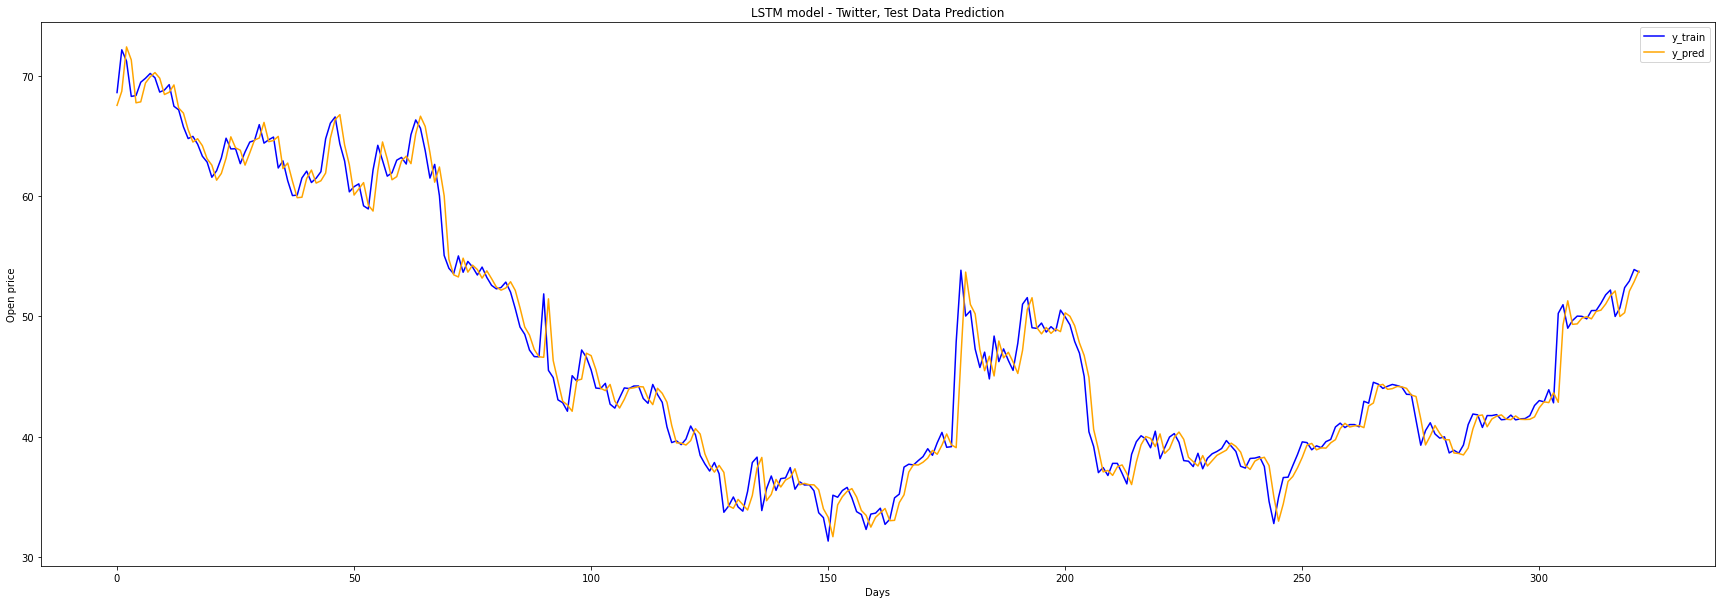

(40, 2.585618824080407, 8.352903215876502, 0.8872060783989925, 2.4726318345265796)


In [8]:
output = train('Twitter', df_twitter, 0.7, 40)
print(output)

Training on Twitter stock data
Original length:  1241
Train length:  869
Valid length:  372


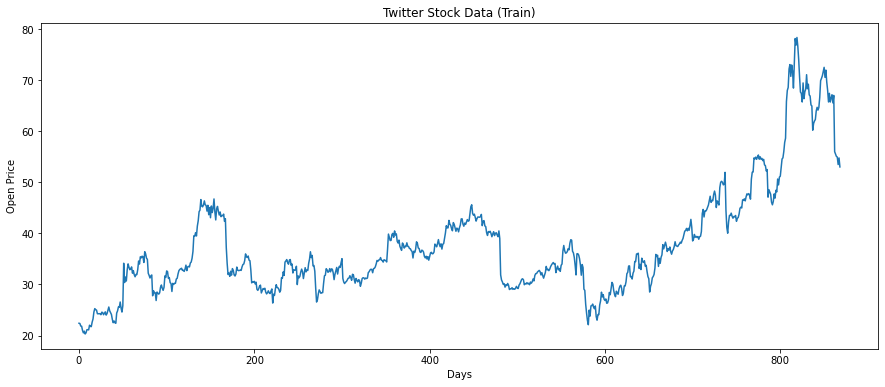

Shape of X_train:  (819, 50, 1)
Shape of y_train:  (819, 1)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "SimpleRNN-Twitter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 50, 50)            2600      
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 50, 50)            5050      
                                                                 
 dropout_5 (Dropout)         (None, 50, 50)            0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 50, 50)            5050      
                                      

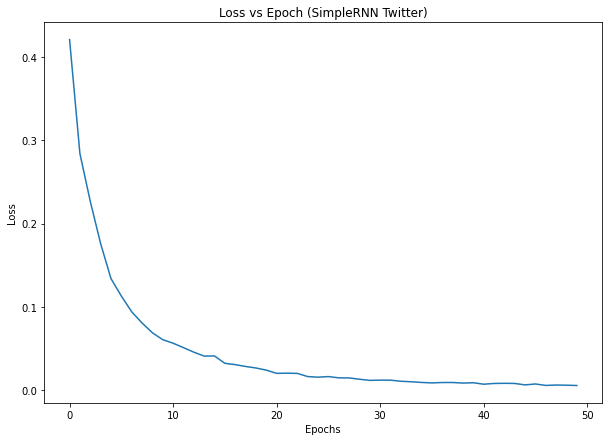

26/26 [==============================] - 2s 11ms/step


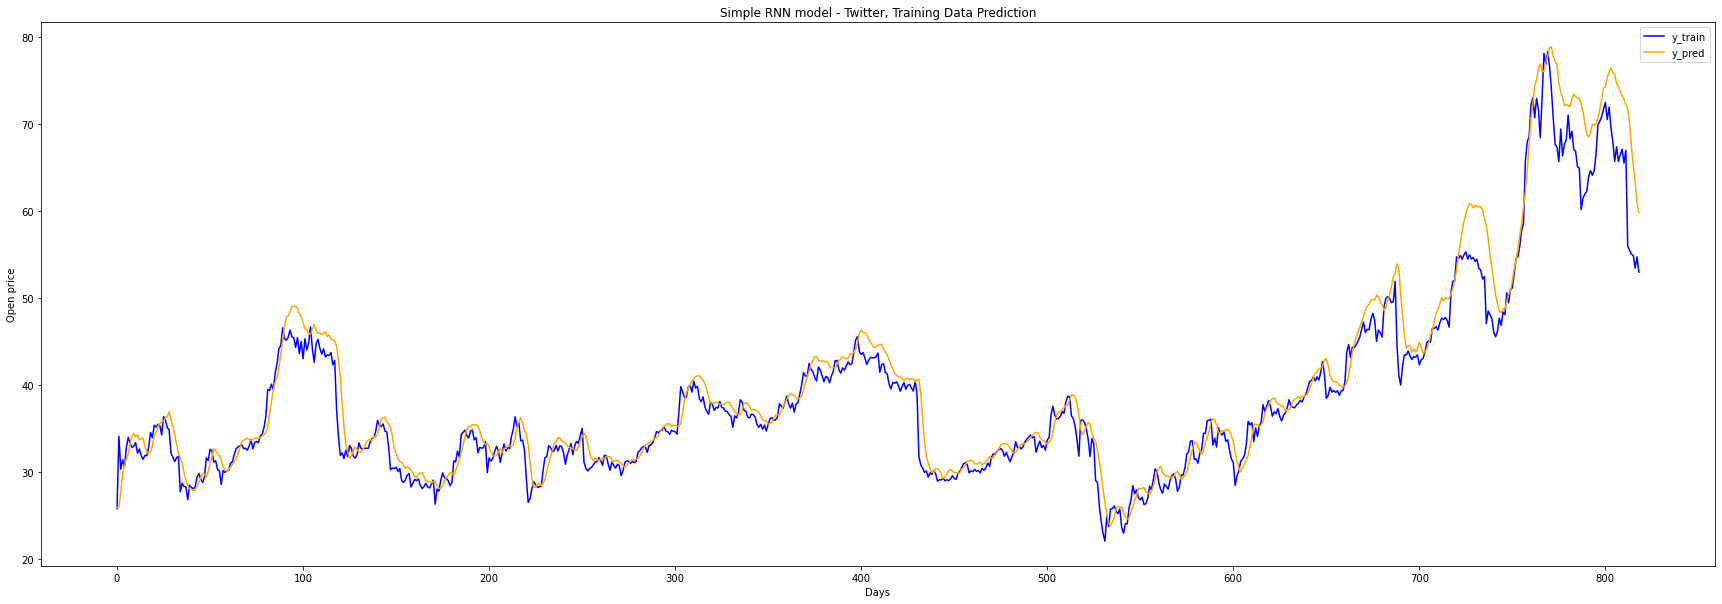

Shape of X_test:  (322, 50, 1)
Shape of y_test:  (322, 1)
11/11 [==============================] - 0s 11ms/step


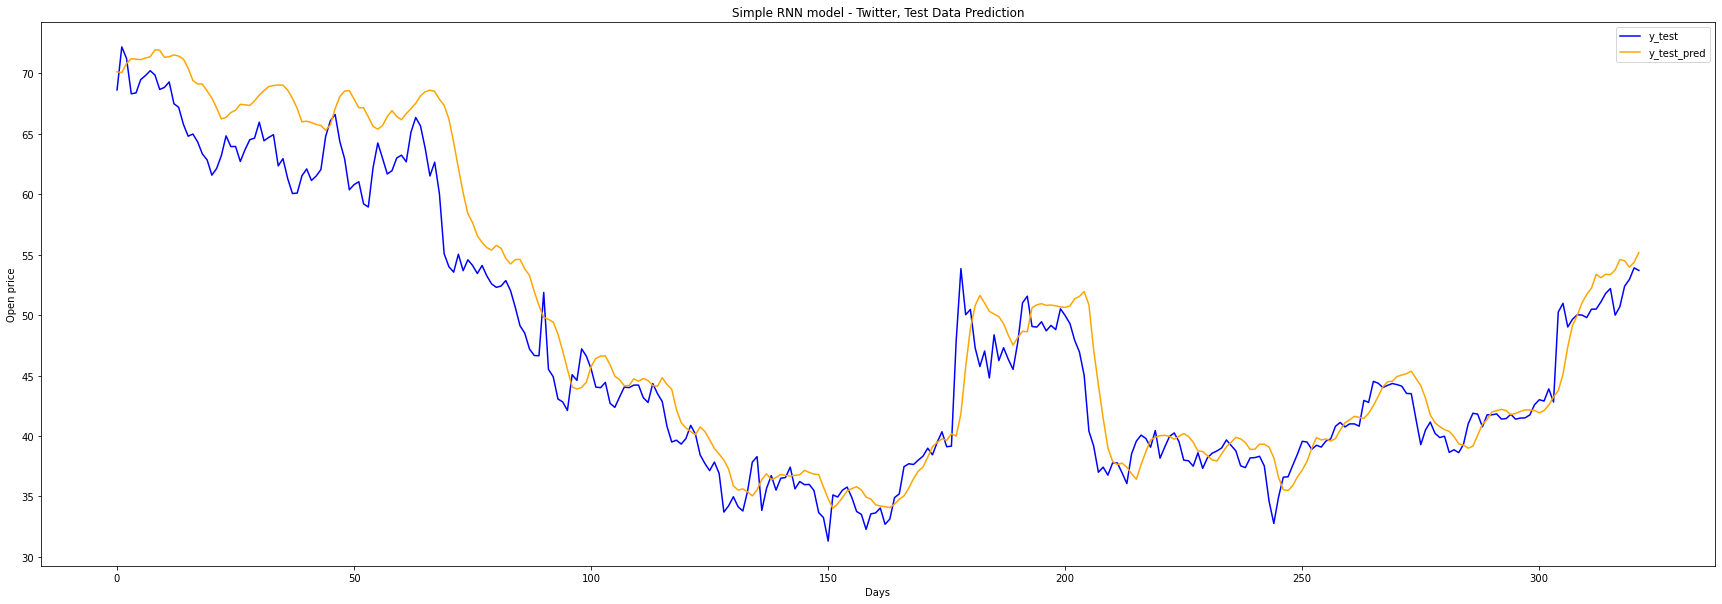


Training LSTM model on Twitter data
Epoch 1/50
82/82 [==============================] - 9s 40ms/step - loss: 0.0083
Epoch 2/50
82/82 [==============================] - 4s 48ms/step - loss: 0.0024
Epoch 3/50
82/82 [==============================] - 4s 45ms/step - loss: 0.0019
Epoch 4/50
82/82 [==============================] - 4s 44ms/step - loss: 0.0019
Epoch 5/50
82/82 [==============================] - 3s 41ms/step - loss: 0.0015
Epoch 6/50
82/82 [==============================] - 4s 44ms/step - loss: 0.0014
Epoch 7/50
82/82 [==============================] - 3s 41ms/step - loss: 0.0015
Epoch 8/50
82/82 [==============================] - 4s 44ms/step - loss: 0.0011
Epoch 9/50
82/82 [==============================] - 3s 42ms/step - loss: 0.0013
Epoch 10/50
82/82 [==============================] - 3s 39ms/step - loss: 0.0011
Epoch 11/50
82/82 [==============================] - 4s 45ms/step - loss: 9.9764e-04
Epoch 12/50
82/82 [==============================] - 3s 41ms/step - loss: 0.0

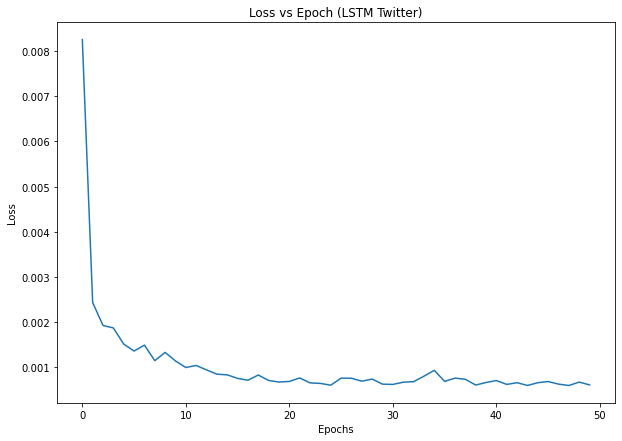

26/26 [==============================] - 2s 13ms/step


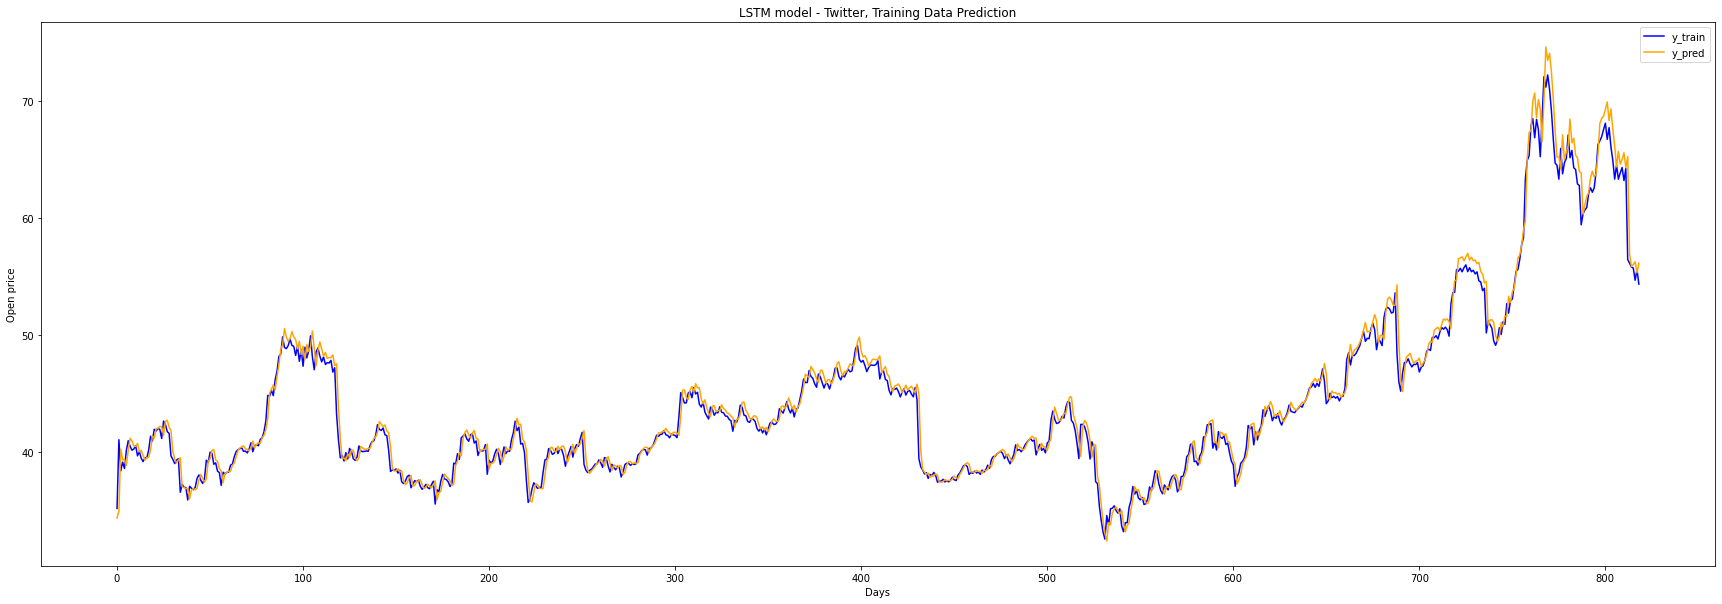

11/11 [==============================] - 0s 12ms/step


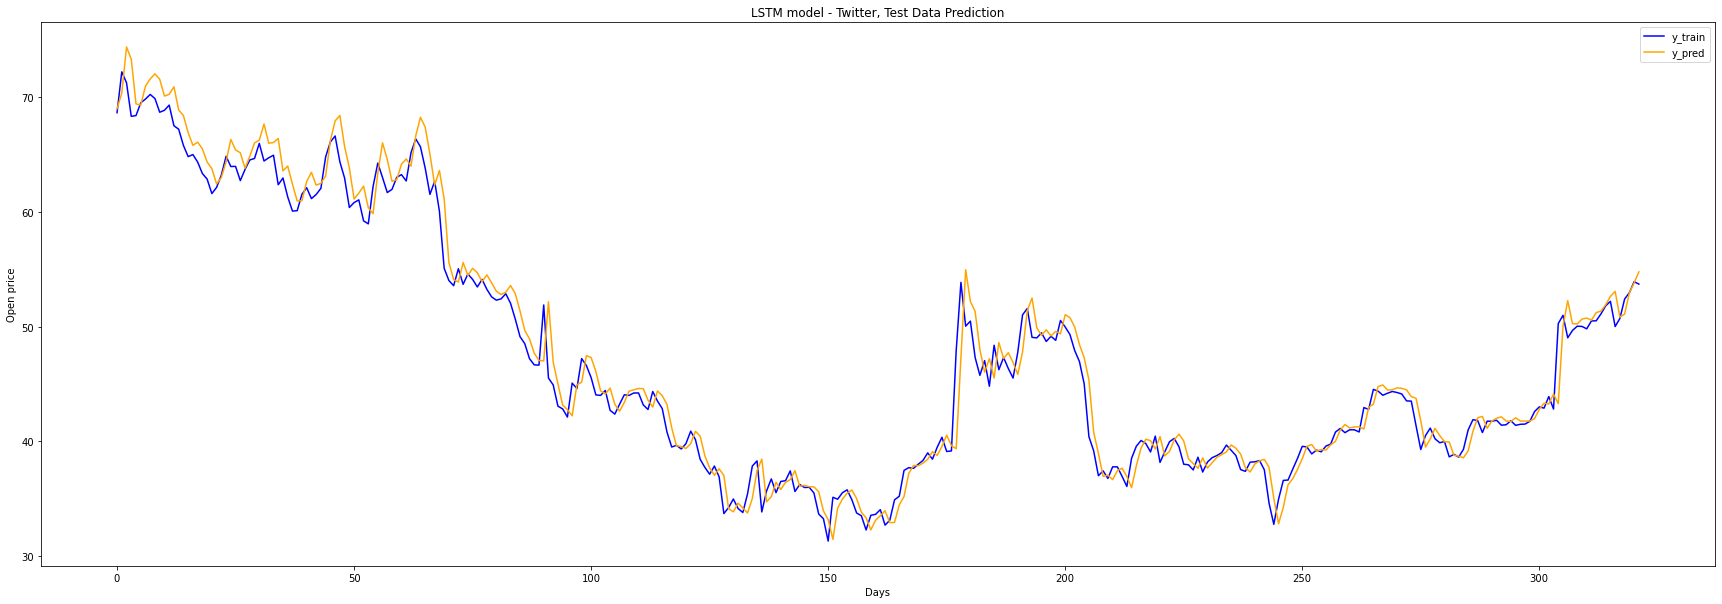

(50, 3.853799111319591, 11.130392747551548, 1.14385177318386, 3.1772531996566653)


In [9]:
output = train('Twitter', df_twitter, 0.7, 50)
print(output)

Training on Twitter stock data
Original length:  1241
Train length:  869
Valid length:  372


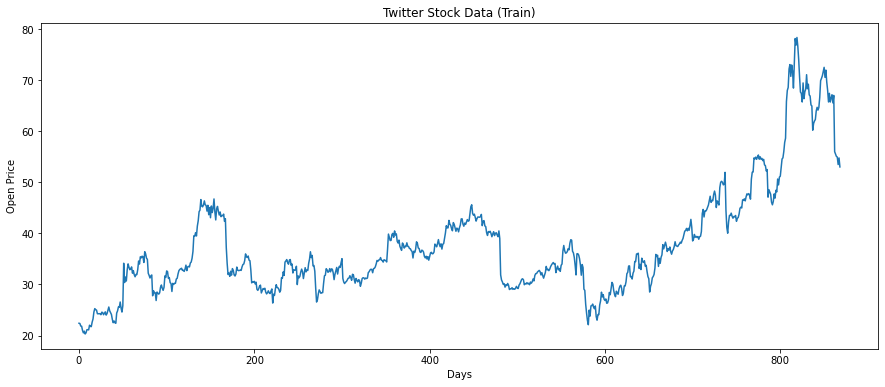

Shape of X_train:  (809, 60, 1)
Shape of y_train:  (809, 1)
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "SimpleRNN-Twitter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 60, 50)            2600      
                                                                 
 dropout_8 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 60, 50)            5050      
                                                                 
 dropout_9 (Dropout)         (None, 60, 50)            0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 60, 50)            5050      
                                      

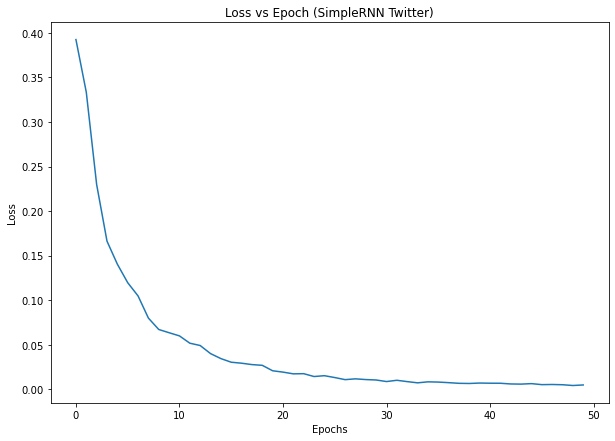

26/26 [==============================] - 1s 12ms/step


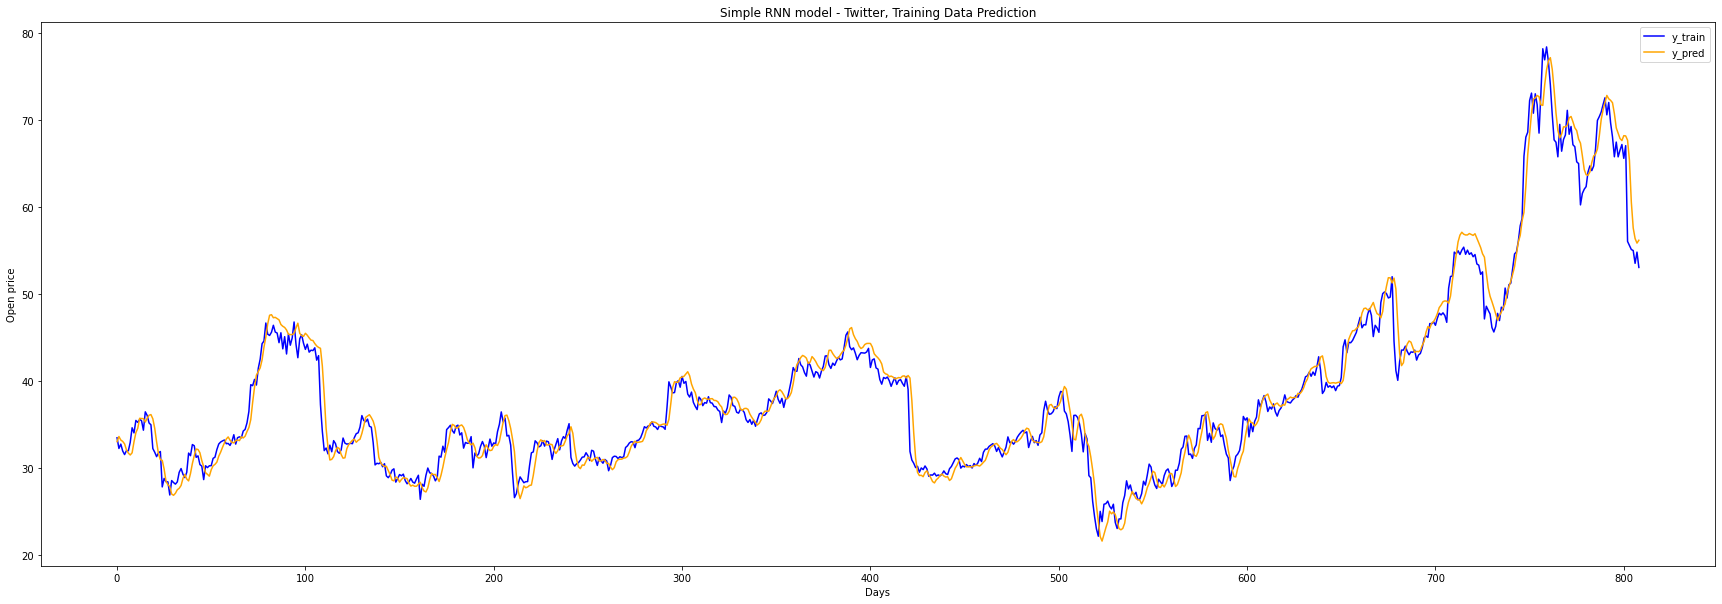

Shape of X_test:  (322, 50, 1)
Shape of y_test:  (322, 1)
11/11 [==============================] - 1s 12ms/step


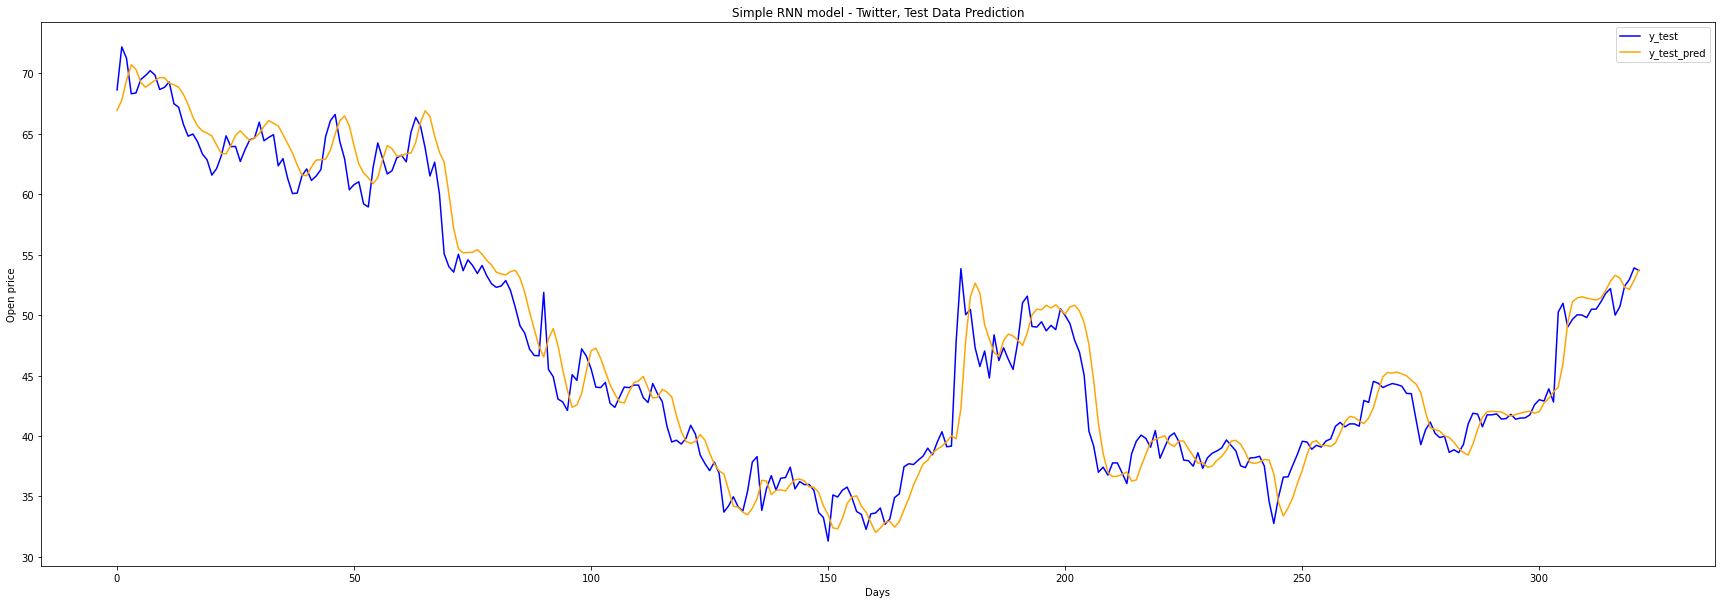


Training LSTM model on Twitter data
Epoch 1/50
81/81 [==============================] - 9s 38ms/step - loss: 0.0079
Epoch 2/50
81/81 [==============================] - 3s 42ms/step - loss: 0.0031
Epoch 3/50
81/81 [==============================] - 4s 45ms/step - loss: 0.0022
Epoch 4/50
81/81 [==============================] - 4s 45ms/step - loss: 0.0020
Epoch 5/50
81/81 [==============================] - 4s 50ms/step - loss: 0.0016
Epoch 6/50
81/81 [==============================] - 4s 45ms/step - loss: 0.0015
Epoch 7/50
81/81 [==============================] - 4s 44ms/step - loss: 0.0013
Epoch 8/50
81/81 [==============================] - 4s 44ms/step - loss: 0.0014
Epoch 9/50
81/81 [==============================] - 4s 47ms/step - loss: 0.0012
Epoch 10/50
81/81 [==============================] - 4s 48ms/step - loss: 0.0011
Epoch 11/50
81/81 [==============================] - 4s 44ms/step - loss: 0.0010
Epoch 12/50
81/81 [==============================] - 4s 45ms/step - loss: 8.9047e

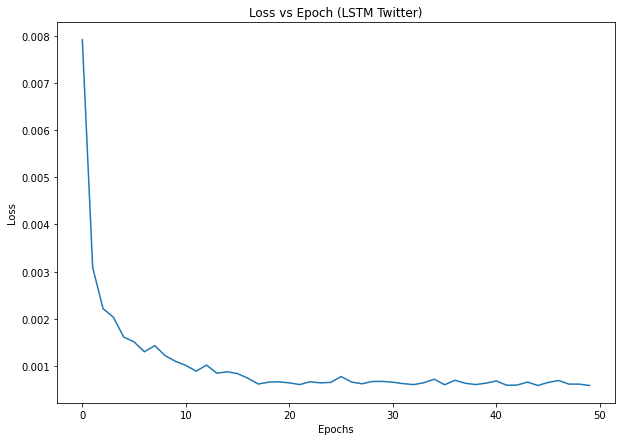

26/26 [==============================] - 1s 13ms/step


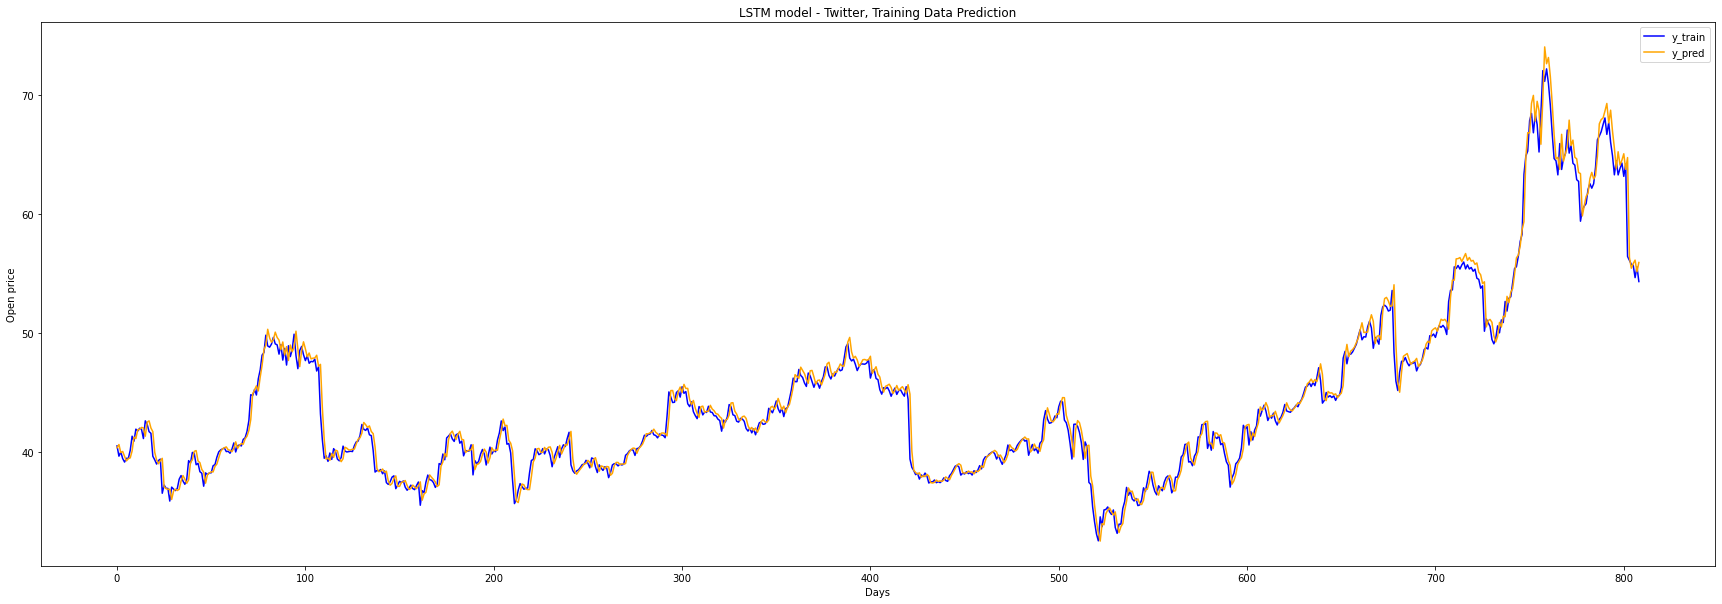

11/11 [==============================] - 1s 11ms/step


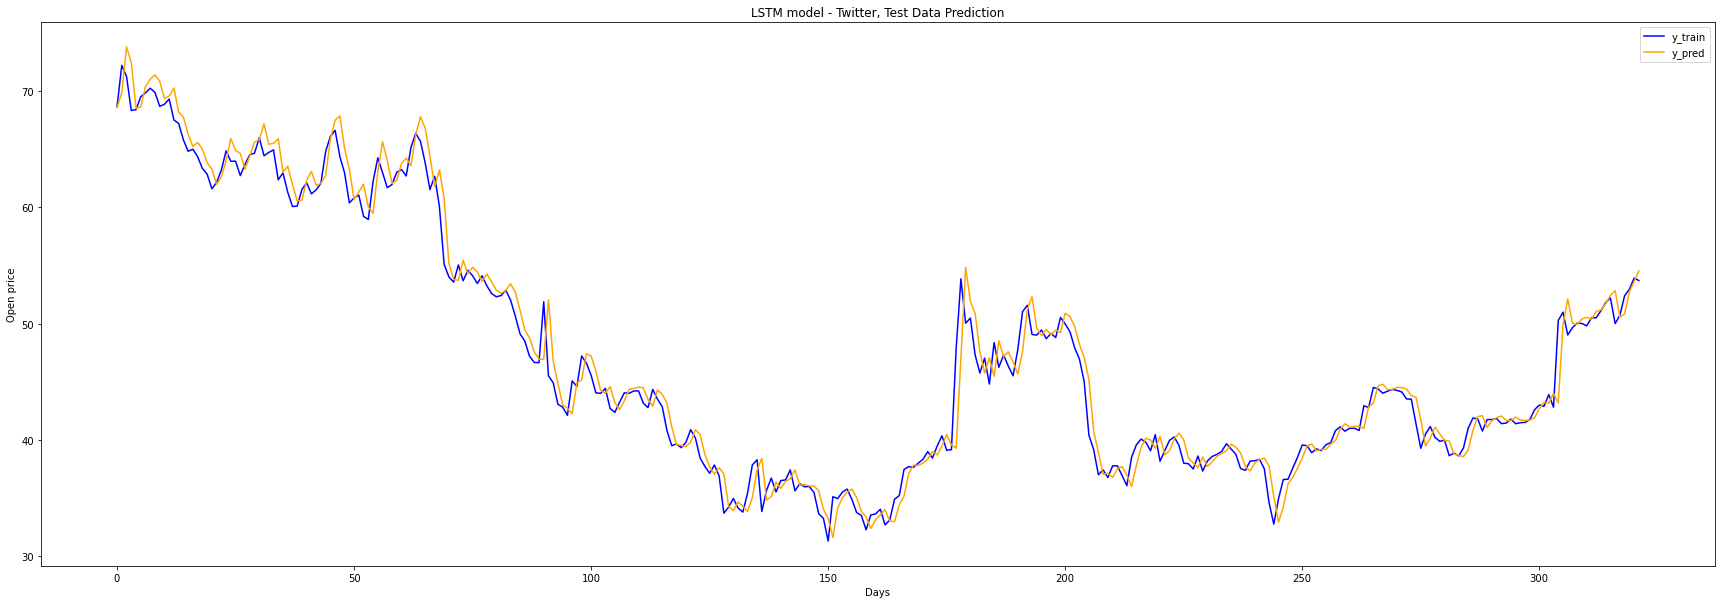

(60, 1.679500411660607, 4.820555702084318, 0.9514400203672162, 2.8219258941775696)


In [10]:
output = train('Twitter', df_twitter, 0.7, 60)
print(output)